<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Loading-Dataset" data-toc-modified-id="Loading-Dataset-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Loading Dataset</a></span></li><li><span><a href="#Reading-TFRecord-Data" data-toc-modified-id="Reading-TFRecord-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Reading TFRecord Data</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model</a></span></li><li><span><a href="#Loading-Model" data-toc-modified-id="Loading-Model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Loading Model</a></span></li></ul></div>

In [1]:
import os
os.chdir("../")

In [2]:
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import IPython.display as display

from vae.config import *
from vae.data_processing import read_tfrecord

Init Plugin
Init Graph Optimizer
Init Kernel


In [3]:
print(f"Tensorflow Version: {tf.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"Numpy Version: {np.__version__}")

Tensorflow Version: 2.5.0
Pandas Version: 1.3.3
Numpy Version: 1.19.5


In [4]:
file_path = MONET_TFREC_PATH + "/*.tfrec"

In [5]:
monet_file_path = glob.glob(MONET_TFREC_PATH + "/*.tfrec")
photo_file_path = glob.glob(PHOTO_TFREC_PATH + "/*.tfrec")
print(len(monet_file_path), len(photo_file_path))

5 20


# Loading Dataset

In [6]:
photo_dataset = tf.data.TFRecordDataset(photo_file_path)
monet_dataset = tf.data.TFRecordDataset(monet_file_path)

Metal device set to: Apple M1


2021-10-08 16:47:54.069466: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-10-08 16:47:54.069570: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Reading TFRecord Data

In [7]:
parsed_monet_dataset = monet_dataset.map(read_tfrecord)
parsed_photo_dataset = photo_dataset.map(read_tfrecord)

In [8]:
def scale_image(data):
    return data/255

scaled_monet_dataset = parsed_monet_dataset.map(scale_image)
scaled_photo_dataset = parsed_photo_dataset.map(scale_image)

# Model

In [9]:
from vae.model import Encoder, Decoder
from vae.model import vae_loss, kl_loss, mse_loss

In [10]:
encoder_model = Encoder()
decoder_model = Decoder()

In [11]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001)

In [12]:
@tf.function
def train_step(img_data, encoder_model, decoder_model):
    
    with tf.GradientTape() as enc_tape, tf.GradientTape() as dec_tape:
        
        mean, log_var, lat_vec = encoder_model(img_data)
        recons_img = decoder_model(lat_vec)
        
        loss = vae_loss(img_data, recons_img, mean, log_var)
        
    
    enc_grad = enc_tape.gradient(loss, encoder_model.trainable_weights)
    dec_grad = dec_tape.gradient(loss, decoder_model.trainable_weights)
    
    optimizer.apply_gradients(zip(enc_grad, encoder_model.trainable_weights))
    optimizer.apply_gradients(zip(dec_grad, decoder_model.trainable_weights))
    
    model_loss = tf.reduce_sum(loss)
    _mse_loss = tf.reduce_sum(mse_loss(img_data, recons_img))
    _kl_loss = tf.reduce_sum(kl_loss(mean, log_var))
    return _mse_loss, _kl_loss, model_loss

In [13]:
def training_exit_flag(loss_vals):
    
    red_loss = []
    
    for i in range(5):
        if i == 4:
            break
#         print(loss_vals[i] - loss_vals[i+1])
        red_loss.append(loss_vals[i] - loss_vals[i+1])
    
    red_loss_flag = [0 if abs(x) > 10 else 1 for x in red_loss]
#     print(red_loss_flag)
    if sum(red_loss_flag) == 5:
        return 1
    else:
        return 0

In [14]:
epoch = 100
recons_loss_list = []
reg_loss_list = []
total_loss_list = []
for i in range(epoch):
    recons_loss, reg_loss, total_loss = 0, 0, 0
    for batch in scaled_monet_dataset.batch(32):
        temp_recons_loss, temp_reg_loss, temp_total_loss = train_step(batch, encoder_model, decoder_model)
        recons_loss += temp_recons_loss
        reg_loss += temp_reg_loss
        total_loss += temp_total_loss
    
    
    recons_loss_list.append(recons_loss)
    reg_loss_list.append(reg_loss)
    total_loss_list.append(total_loss)
    print(f"Epoch: {i+1}; Recons Loss: {recons_loss}; Reg Loss: {reg_loss}; Total Loss: {total_loss}")
    
    if i > 6:
        if training_exit_flag(total_loss_list[-5:]) == 1:
            print(f"Training Exist at Epoch: {i}")
            encoder_model.save("saved_model/encoder_model/")
            decoder_model.save("saved_model/decoder_model/")
            break

2021-10-08 16:47:54.170489: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-08 16:47:54.170628: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-10-08 16:47:54.849713: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-10-08 16:48:15.046346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch: 1; Recons Loss: 16287.5908203125; Reg Loss: 163.5072479248047; Total Loss: 16451.099609375
Epoch: 2; Recons Loss: 16226.833984375; Reg Loss: 1.142154335975647; Total Loss: 16227.9765625
Epoch: 3; Recons Loss: 16116.296875; Reg Loss: 4.5699238777160645; Total Loss: 16120.8671875
Epoch: 4; Recons Loss: 15938.091796875; Reg Loss: 13.565183639526367; Total Loss: 15951.6572265625
Epoch: 5; Recons Loss: 15656.3388671875; Reg Loss: 12.2283353805542; Total Loss: 15668.568359375
Epoch: 6; Recons Loss: 15315.63671875; Reg Loss: 47.925106048583984; Total Loss: 15363.5615234375
Epoch: 7; Recons Loss: 14878.205078125; Reg Loss: 143.70620727539062; Total Loss: 15021.91015625
Epoch: 8; Recons Loss: 14276.740234375; Reg Loss: 345.85614013671875; Total Loss: 14622.5966796875
Epoch: 9; Recons Loss: 13362.025390625; Reg Loss: 597.467529296875; Total Loss: 13959.494140625
Epoch: 10; Recons Loss: 12525.390625; Reg Loss: 754.0037231445312; Total Loss: 13279.392578125
Epoch: 11; Recons Loss: 11829.802

Epoch: 86; Recons Loss: 9867.9560546875; Reg Loss: 852.5603637695312; Total Loss: 10720.5166015625
Epoch: 87; Recons Loss: 9796.033203125; Reg Loss: 816.967041015625; Total Loss: 10612.998046875
Epoch: 88; Recons Loss: 9903.14453125; Reg Loss: 811.7612915039062; Total Loss: 10714.90625
Epoch: 89; Recons Loss: 9789.7802734375; Reg Loss: 822.7468872070312; Total Loss: 10612.5283203125
Epoch: 90; Recons Loss: 9895.6171875; Reg Loss: 840.7286376953125; Total Loss: 10736.3447265625
Epoch: 91; Recons Loss: 9952.83984375; Reg Loss: 831.123779296875; Total Loss: 10783.9638671875
Epoch: 92; Recons Loss: 9804.296875; Reg Loss: 856.7999877929688; Total Loss: 10661.0966796875
Epoch: 93; Recons Loss: 9768.7548828125; Reg Loss: 819.5419311523438; Total Loss: 10588.296875
Epoch: 94; Recons Loss: 9856.501953125; Reg Loss: 825.5975341796875; Total Loss: 10682.0986328125
Epoch: 95; Recons Loss: 9916.7421875; Reg Loss: 828.8782348632812; Total Loss: 10745.62109375
Epoch: 96; Recons Loss: 9810.3779296875;

# Loading Model

In [81]:
decoder_model = tf.keras.models.load_model("saved_model/decoder_model/")
encoder_model = tf.keras.models.load_model("saved_model/encoder_model/")

In [82]:
for batch in scaled_monet_dataset.batch(32).take(1):
    data = batch

In [83]:
encoder_out = encoder_model.predict(data)

2021-10-08 17:52:47.998432: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


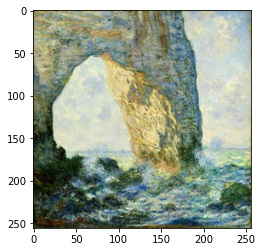

In [84]:
plt.imshow(data[0])
plt.show()

2021-10-08 17:52:50.614078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


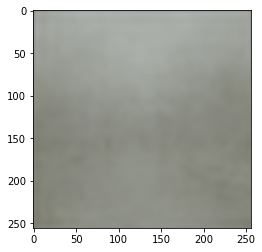

In [85]:
plt.imshow(decoder_model(np.reshape(encoder_out[2][0], (1, 2)))[0])
plt.show()